## Background Statement
Data is collected from a UK-based retail e-commerce company containing all the transactions occurring between 01/12/2010 & 09/12/2011. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

from prince import CA

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_excel('full_data.xlsx')

In [3]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [5]:
null_col = ((df.isnull().sum())/ len(df) * 100).sort_values(ascending = False)
null_col = null_col.drop(null_col[null_col == 0 ].index)
null_col

CustomerID     24.926694
Description     0.268311
dtype: float64

Given that this behavioural analysis is heavily individual centric, missing value on customer id can only be dealt with by removing it.

There might be duplications in the data, which needs to be dropped too.

In [6]:
df= df.dropna(subset = ['CustomerID'])
df = df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Checking feature's logicical value.

    Quantity cannot be negative.
    Price cannot be negative.

Some entries' quantity possesses negative value, hence needs to be removed.

In [7]:
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]
df.shape

(392692, 8)

In [42]:
Map = df.groupby(['CustomerID', 'Country']).size().reset_index().iloc[:, 1:-1]
Map = Map['Country'].value_counts().to_frame().reset_index()

In [43]:
gapminder = px.data.gapminder().query("year==2007")
gapminder['country'].drop_duplicates(inplace = True)

isocode = {}
for a, b in zip(gapminder.country, gapminder.iso_alpha):
    isocode[a] = b

def mapping(x):
    try:
        return isocode[x]
    except:
        if x == 'USA':
            return isocode['United States']
        
        elif x == 'United Arab Emirates':
            return 'ARE'
        
        else:
            return None
        
continent = {}
for a, b in zip(gapminder.country, gapminder.continent):
    continent[a] = b

def region(x):
    try:
        return continent[x]
    except:
        if x == 'USA':
            return 'Americas'
        else:
            return None

In [44]:
df['Continent'] = [region(x) for x in df.Country.values]

In [45]:
Map['ISO'] = [mapping(x) for x in Map['index']]
Map =  Map.dropna(subset = ['index'])
Map['Log_Value'] = np.log(Map['Country'])

In [46]:
fig = px.choropleth(Map, locations = "ISO",
                    color = "Log_Value", 
                    hover_name = "index", 
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(title = 'Customer Base (Population) - Log Value',
                  margin = dict(l = 20, r = 20, t = 30, b = 10))
fig.show()
print('Most Customer Base is heavily focusing on European Countries primarily on UK.')

del gapminder, Map

Most Customer Base is heavily focusing on European Countries primarily on UK.


## Cohort Analysis
Cohort Analysis is a subset of behavioural analytics tht breaks data into related groups for analysis (cohorts), cohorts are believe to share common characteristics within a time-span.
<ul>
1) "Inv_Month" is essentially month for which the invoice was created.
    
2) "Cohort_Month" represent a particular cohort's first purchase made.
</ul>

In [13]:
df['Inv_Month'] = [dt(x.year, x.month, 1) for x in df.InvoiceDate]

groups = df.groupby('CustomerID')['Inv_Month']
df['CohortMonth'] = groups.transform(min)

<ul>
3) "Cohort_Index" is the month differences between invoice month & cohort month.
</ul>

In [14]:
def time_extract(column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

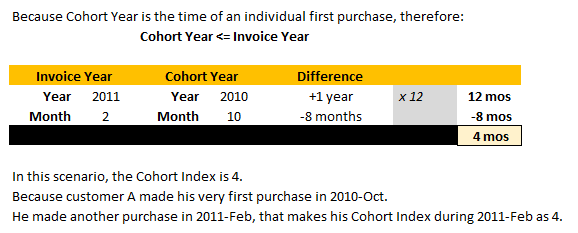

In [15]:
invoice_year, invoice_month = time_extract('Inv_Month')
cohort_year, cohort_month = time_extract('CohortMonth')

In [16]:
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

In [17]:
df['CohortIndex'] = (year_diff * 12) + month_diff

<ul>
4) Count monthly active customers from each cohort index in each respective timeline.
</ul>

In [18]:
cohort_table = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique)
cohort_table = cohort_table.reset_index()
cohort_table = cohort_table.pivot(index = 'CohortMonth',
                                  columns = 'CohortIndex',
                                  values = 'CustomerID')

In [19]:
retention_table = cohort_table.divide(cohort_table.iloc[:, 0], axis = 0) * 100

In [20]:
import datetime

### Create Labels for Heatmap's Y axis.
months = []
for year, month in zip(retention_table.index.year, retention_table.index.month):
    months.append(datetime.date(year, month, 1).strftime('%b %Y'))

In [21]:
text = np.round(retention_table.fillna(0).values, 0).astype(int)

fig = ff.create_annotated_heatmap(z = np.round(retention_table.fillna(0).values, 0).astype(int), 
                                  x = retention_table.columns.tolist(),
                                  y = months,
                                  annotation_text = np.where(text == 0, ' ', text),
                                  colorscale = 'Viridis')

fig.update_layout(width = 800, height = 500,
                  title = 'Retention Rate(%) Table',
                  xaxis_title = 'Cohort Index',
                  yaxis = dict(autorange = 'reversed'),
                  margin = dict(l = 20, r = 20, t = 30, b = 20))

fig.show()

Retention information provides insights for how many of the customers are still active over time.
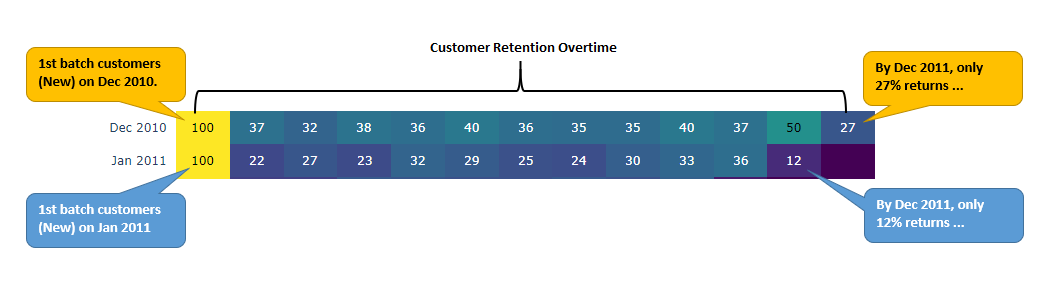

## Recency, Frequency & Monetary (RFM)

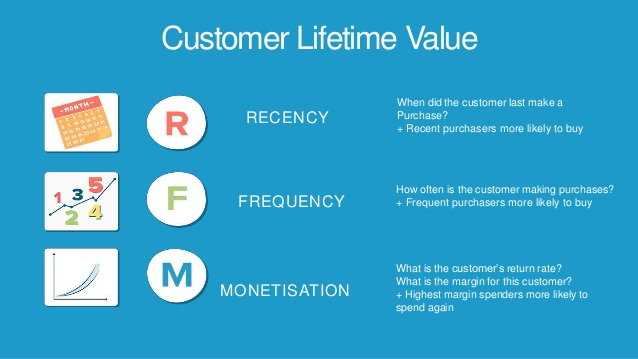

In [22]:
df['Total_Sales'] = df['UnitPrice'].values * df['Quantity'].values

In [23]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo' : 'count',
                                      'Total_Sales': 'sum'})

rfm.rename(columns={'InvoiceDate' : 'Recency',
                    'InvoiceNo' : 'Frequency',
                    'Total_Sales' : 'Monetary'}, inplace= True)

In [24]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


Assume today is Dec 10th...

We can see that Customer 12346 hasn't been coming back for 326 days & has 1 time purchase with a total purchases of $77,184.

Whereas Customer 12347 is a frequent customer that has made 182 transactions totalled $4,310.

### Binning RFM
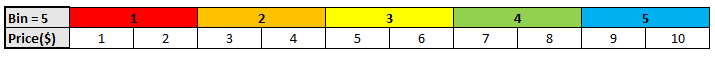
Let's setup a 5-binning threshold for the metrics, e.g. Monetary value above $10,000 will be classified as 5.

<b>Log Transformation</b>

As the distribution is not normal, log transformation has been applied.

In [25]:
for _ in ['Recency', 'Frequency', 'Monetary']:
    TEMP = np.log(rfm[_].values)
    
    fig = ff.create_distplot([TEMP], [str(_)], show_hist = False)
    fig.update_layout(width = 600, height = 300,
                      margin = dict(l = 20, r = 20, t = 30, b = 20))
    fig.show()
    print(f'{_} Metrics')
    print(f'| Min. Log Value: {TEMP.min()}')
    print(f'| Avg. Log Value: {TEMP.mean()}')
    print(f'| Max. Log Value: {TEMP.max()}')

Recency Metrics
| Min. Log Value: 0.0
| Avg. Log Value: 3.7675337238080164
| Max. Log Value: 5.924255797414532


Frequency Metrics
| Min. Log Value: 0.0
| Avg. Log Value: 3.6715221940070353
| Max. Log Value: 8.94585385712759


Monetary Metrics
| Min. Log Value: 1.3217558399823195
| Avg. Log Value: 6.585704306454773
| Max. Log Value: 12.54328039730807


In [26]:
rfm['Recency_Quartile'] = pd.qcut(np.log(rfm['Recency']), q = 5, labels = [5, 4, 3, 2, 1])
rfm['Frequency_Quartile'] = pd.qcut(np.log(rfm['Frequency']), q = 5, labels = [1, 2, 3, 4, 5])
rfm['Monetary_Quartile'] = pd.qcut(np.log(rfm['Monetary']), q = 5, labels = [1, 2, 3, 4, 5])

In [27]:
rfm['Segment'] = [str(a)+str(b)+str(c) for a, b, c
                  in zip(rfm['Recency_Quartile'].values,
                         rfm['Frequency_Quartile'].values,
                         rfm['Monetary_Quartile'].values)]

In [28]:
rfm['Score'] = [int(a) + int(b) + int(c) for a, b, c
                in zip(rfm['Recency_Quartile'].values,
                       rfm['Frequency_Quartile'].values,
                       rfm['Monetary_Quartile'].values)]

In [29]:
rfm.head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,Segment,Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,182,4310.00,5,5,5,555,15
12348.0,75,31,1797.24,2,3,4,234,9
12349.0,19,73,1757.55,4,4,4,444,12
12350.0,310,17,334.40,1,2,2,122,5


In [30]:
rfm.groupby('Score').agg({'Recency': 'median',
                          'Frequency': 'median',
                          'Monetary': ['median', 'count'] }).round(0).astype(int)

Recency Frequency Monetary      
       median    median   median count
Score                                 
3         275         7      137   271
4         190        10      188   260
5         185        16      303   368
6          97        18      322   385
7          66        24      407   383
8          74        32      550   365
9          53        42      690   359
10         45        55      863   350
11         32        71     1117   336
12         25        90     1423   335
13         18       120     2003   314
14         16       190     3009   306
15          4       270     4599   306

<b>Interpretation on Median Information:</b>

When Score == 3:

    The cohorts of score 3 (271 individuals):
        > They haven't been coming back for 275 days on average.
        > They have only purchase items 7 times on average historically.
        > They have spent total value of 137 dollar on average.
        
### Insights on Top 3 Segments (Unique Customer Wise)

In [31]:
rfm['Segment'].value_counts()[:3]

555    306
111    271
455    170
Name: Segment, dtype: int64

In [32]:
segment_dict = rfm['Segment'].to_dict()
df['Segment'] = [segment_dict[x] for x in df.CustomerID.values]

In [33]:
for _ in ['555', '111', '455']:
    X = df['Description'][df.Segment == _].value_counts().to_dict()
    
    fig = go.Figure(data = [go.Pie(labels = list(X.keys())[0:5], 
                                   values = list(X.values())[0:5])
                           ])
    
    fig.update_layout(width = 800, height = 300,
                      title = 'Group ' + str(_) + "'s Top 5 Purchases",
                      margin = dict(l = 10, r = 50, t = 30, b = 10))
    fig.show()

In [34]:
Items = df['Description'][(df.Segment == '555') |
                          (df.Segment == '111') |
                          (df.Segment == '455')]

Items = Items.value_counts()[:10]

In [35]:
fig = go.Figure([go.Bar(x = Items.values, y = Items.index,
                 orientation = 'h')])

fig.update_layout(width = 800, height = 400,
                  title = '10 Popular Items in Top 3 Segment',
                  margin = dict(l = 10, r = 10, t = 100, b = 10))

fig.show()

## Correspondence Analysis
Checking the top 25 popular items association geographically, <b>excluding European countries</b>.

In [36]:
X = df[df.Continent != 'Europe']
X = X[X.Description.isin(X.Description.value_counts()[:100].index)]

cont_tab = pd.crosstab(X.Description, X.Country)

ca = CA(n_components = 2, n_iter = 10, random_state = 42)
ca = ca.fit(cont_tab)

In [37]:
col = ca.column_coordinates(cont_tab)
row = ca.row_coordinates(cont_tab)

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = row.iloc[:, 0], y = row.iloc[:, 1], 
                         text = row.index, textposition = "bottom center",
                         mode = 'markers', name = 'Item Type'))

fig.add_trace(go.Scatter(x = col.iloc[:, 0], y = col.iloc[:, 1], 
                         text = col.index, textposition = "bottom center",
                         mode = 'markers+text', name = 'Country'))

fig.update_layout(width = 800, height = 600,
                  title = 'Correspondence Analysis - Principal Coordinates (Non-European Countries)',
                  margin = dict(l = 10, r = 10, t = 50, b = 10))

fig.show()

In [39]:
X = df[(df.Continent == 'Europe') & (df.Country != 'United Kingdom')]
X = X[X.Description.isin(X.Description.value_counts()[:100].index)]

cont_tab = pd.crosstab(X.Description, X.Country)

ca = CA(n_components = 2, n_iter = 10, random_state = 42)
ca = ca.fit(cont_tab)

In [40]:
col = ca.column_coordinates(cont_tab)
row = ca.row_coordinates(cont_tab)

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = row.iloc[:, 0], y = row.iloc[:, 1], 
                         text = row.index, textposition = "bottom center",
                         mode = 'markers', name = 'Item Type'))

fig.add_trace(go.Scatter(x = col.iloc[:, 0], y = col.iloc[:, 1], 
                         text = col.index, textposition = "bottom center",
                         mode = 'markers+text', name = 'Country'))

fig.update_layout(width = 800, height = 600,
                  title = 'Correspondence Analysis - Principal Coordinates (European Countries)',
                  margin = dict(l = 10, r = 10, t = 50, b = 10))

fig.show()

## Further Possible Attempts
<ul>
    <li>Cluster Analysis on Customer Segmentation</li>
    <li>Correspondence Analysis on Months & Items</li>
    </ul>